In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Install packages
!pip install multi_key_dict
!pip install word2number

  Created wheel for multi-key-dict: filename=multi_key_dict-2.0.3-cp36-none-any.whl size=9300 sha256=6d2637f51902c18ea0722dabc928b8a0116eefa579743875e86468ddcf0cd044
  Stored in directory: /root/.cache/pip/wheels/1d/26/5b/ac32658fddc88f045a516406ff69cafabaab2602eb96bbe2f0
Successfully built multi-key-dict
  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5588 sha256=03ceabaefe275da2076ecfe0abbd37e2bb62f80118beed239c3b75aa559f24e2
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number


In [0]:
# imports
import nltk
from nltk.stem import WordNetLemmatizer
import pickle
import argparse
from collections import Counter
import json
import os
from tqdm import *
import numpy as np
import re
from multi_key_dict import multi_key_dict
from word2number import w2n
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# path to data files
DATA_PATH = "/content/drive/My Drive/Intro to AI Project/data/"

##Rules for ingredients cleaning

In [0]:
lemmatizer = WordNetLemmatizer()
#\d: decimal; \s: whitespace; 
# pattern of units
num_units = re.compile(r'(\d)+(\s)?(cubes?|cups?|c(a?ns?)?|[tT]|bulbs?|sprigs?|glass(es)?|dice|blocks?|an?|l|fl(uid)?\.?|ears?|lea(f|ves)|jars?|cartons?|strips?|heads?|wedges?|envelopes?|pints?|stalks?|sticks?|pinch(es)?|qts?|quarts?|handful|weight|bottles?|grinds?|tb\.?|lbs?\.?|oz\.?|mls?|g|cloves?|containers?|tablespoons?|teaspoons?|dash(es)?|pounds?|pinch|box(es)?|cans?|(milli)?lit[er]{2}s?|pkg\.?|pack(et)s?|packages?|whole|bars?|bags?|tbsps?\.?|tbs\.?|ts|tsps?\.?|ounces?|dash|pieces?|slices?|bunch(es)?|sticks?|fl\.?|gallons?|squares?|knobs?|grams?|kgs?|tub(es)?|kilograms?|tins?|%|drizzles?|splash(es)?|chunks?|inch(es)?)(\s|$)')
   
replace_dict_ingrs = multi_key_dict()
replace_dict_ingrs['&',"'n"] = ' and '
replace_dict_ingrs['-'] = ' '

# preprocess text for ingredients 
def get_ingredient(det_ingr):
    det_ingr = det_ingr['text'].lower()
    re.sub("[\(\[\{].*?[\)\]\}]", "", det_ingr) #remove text in parentheses
    re.sub(num_units,"",det_ingr) #remove units
    for k_list in replace_dict_ingrs.keys():
      for k in k_list:
        if k in det_ingr:
          det_ingr = det_ingr.replace(k,replace_dict_ingrs[k]) #replace characters like (& n -)        
    cleaned_list = []
    for word in det_ingr.split():
      if word.isalpha():  # word only, no numbers or other symbols
        cleaned_list.append(lemmatizer.lemmatize(word)) 
    det_ingr_cleaned = " ".join(cleaned_list)
    return det_ingr_cleaned

# function testing
get_ingredient({"text":"1g salt salmon"})

'salt salmon'

##Rules for instructions cleaning

In [0]:
# using multi_key_dict to reduce dimensionality and standardize certain terms
replace_dict_instrs = multi_key_dict()
replace_dict_instrs[' nonfat ', ' non-fat '] = ' fat-free '
replace_dict_instrs['low-fat', 'reduced-fat'] = ' fat-reduced '
replace_dict_instrs[' flatleaf '] = ' flat-leaf '
replace_dict_instrs['&',"'n"] = ' and '
replace_dict_instrs['!','?'] = '.'
replace_dict_instrs[';',':'] = '.'
replace_dict_instrs['-','(',')',"[",']',"#","$"] = ' '
replace_dict_instrs[' a '," an "] = ' 1 '

# unit conversions: standardize units
unit_conversions = multi_key_dict()
unit_conversions['pounds', 'pound', 'lbs', 'lb'] = ('g', 453.6)
unit_conversions['ounces', 'ounce', 'ozs', 'oz', 'weight'] = ('g', 28.35)
unit_conversions['can', 'cans', 'cn'] = ('can', 1)
unit_conversions['pints', 'pint', 'pts', 'pt'] = ('l', 0.4732)
unit_conversions['quarts', 'quart', 'qts', 'qt'] = ('l', 1.946352946)
unit_conversions['cups', 'cup', 'c'] = ('l', 0.2366)
unit_conversions['cubes', 'cube'] = ('cube', 1)
unit_conversions['fluid', 'fl'] = ('l', 0.02957)
unit_conversions['tablespoons', 'tablespoon', 'tbsps', 'tbsp', 'tb', 'tbs', 'T'] = ('l', 0.01479)
unit_conversions['teaspoons', 'teaspoon', 'tsps', 'tsp', 't', 'ts'] = ('l', 0.004929)
unit_conversions['milliliters', 'millilitres', 'ml'] = ('l', 0.001)
unit_conversions['gram', 'gs', 'grams'] = ('g', 1)
unit_conversions['kilogram', 'kgs', 'kg', 'kilograms'] = ('g', 0.001)

# preprocess text for instructions 
def get_instruction(instruction, instruction_mode=True):
    instruction = instruction.lower()
    re.sub("[\(\[\{].*?[\)\]\}]", "", instruction) #remove text in parentheses
    for k_list in replace_dict_instrs.keys():
      for k in k_list:
        if k in instruction:
          instruction = instruction.replace(k,replace_dict_instrs[k]) # use rules to standardize labels
    instruction = instruction.replace('half','1/2') # should it be inluded above?
    cleaned_list = []
    # unit conversion
    words = instruction.split()
    for i in range (len(words)):
      if words[i] in unit_conversions:
        try:
          # the word before unit is most likely a number
          num = w2n.word_to_num(words[i-1])
          # unit conversion
          num = round(num/unit_conversions[words[i]][1],2)
          cleaned_list[-1] = str(num)
          cleaned_list.append(unit_conversions[words[i]][0])
          continue
        except:
          pass
        try:
          num = words[i-1]
          if '/' in num:
            num = float(num.split('/')[0])/float(num.split('/')[1])
          else:
            num = float(num)
          num = round(num/unit_conversions[words[i]][1],2)
          cleaned_list[-1] = str(num)
          cleaned_list.append(unit_conversions[words[i]][0])
          continue
        except:
          pass
      else:
        cleaned_list.append(words[i])
                                      
    instruction = " ".join(cleaned_list)
    # instruction too short to be valid
    if len(instruction) < 3:  
      return ""
    # Remove "1." or "2." for steps -> for model  
    if len(instruction) > 0 and instruction[0].isdigit() and instruction[1] == '.' and instruction_mode:
        instruction = instruction[2:].strip()
    return instruction
 
# function testing
print (get_instruction("1.Arrange 3/5 kg veggies on top of 6 oz salmon 'n seal foil tightly to create a tightly sealed pocket."))
print (get_instruction("1."))

arrange 600.0 g veggies on top of 0.21 g salmon and seal foil tightly to create 1 tightly sealed pocket.



Import and Process Recipe Data from Recipe1M json files

In [0]:
print ("Loading data...")
dets = json.load(open(os.path.join(DATA_PATH, 'det_ingrs.json'), 'r'))
layer1 = json.load(open(os.path.join(DATA_PATH, 'layer1.json'), 'r'))

print("Loaded data.")
print("Found %d recipes in the dataset." % (len(layer1)))
    
# dict with id as key and number as value
dataset = {}
idx2ind = {}
for i, entry in enumerate(dets):
    idx2ind[entry['id']] = i

for i, entry in tqdm(enumerate(layer1)):
    # get all instructions for this recipe
    instrs = entry['instructions']
    instrs_list = []
    ingrs_list = []
    # retrieve pre-detected ingredients for this entry
    det_ingrs = dets[idx2ind[entry['id']]]['ingredients']
    valid = dets[idx2ind[entry['id']]]['valid']
    for j, det_ingr in enumerate(det_ingrs):
        if len(det_ingr) > 0 and valid[j]:
            det_ingr_undrs = get_ingredient(det_ingr)
            if len(det_ingr_undrs) > 0:
              ingrs_list.append(det_ingr_undrs)

    # get raw text for instructions of this entry
    acc_len = 0
    for instr in instrs:
        instr = instr['text']
        instr = get_instruction(instr)
        if len(instr) > 0:
            instrs_list.append(instr)
            acc_len += len(instr)

    # discard recipes with too few or too many ingredients or instruction words
    if len(ingrs_list) < 2 or len(instrs_list) < 2 \
        or len(instrs_list) >= 20 or len(ingrs_list) >= 20 \
        or acc_len < 20:
        continue

    title = get_instruction(entry['title'])

    newentry = {'id': entry['id'], 'instructions': instrs_list,
                    'ingredients': ingrs_list, 'title': title}
    if entry['partition'] not in dataset:
        dataset[entry['partition']]=[]
    dataset[entry['partition']].append(newentry)

Loading data...
Loaded data.
Found 1029720 recipes in the dataset.


1029720it [06:32, 2625.41it/s]


In [0]:
# A sample of original recipe text in json format
layer1[1]

{'id': '000033e39b',
 'ingredients': [{'text': '1 c. elbow macaroni'},
  {'text': '1 c. cubed American cheese (4 ounce.)'},
  {'text': '1/2 c. sliced celery'},
  {'text': '1/2 c. minced green pepper'},
  {'text': '3 tbsp. minced pimento'},
  {'text': '1/2 c. mayonnaise or possibly salad dressing'},
  {'text': '1 tbsp. vinegar'},
  {'text': '3/4 teaspoon salt'},
  {'text': '1/2 teaspoon dry dill weed'}],
 'instructions': [{'text': 'Cook macaroni according to package directions; drain well.'},
  {'text': 'Cold.'},
  {'text': 'Combine macaroni, cheese cubes, celery, green pepper and pimento.'},
  {'text': 'Blend together mayonnaise or possibly salad dressing, vinegar, salt and dill weed; add in to macaroni mix.'},
  {'text': 'Toss lightly.'},
  {'text': 'Cover and refrigeratewell.'},
  {'text': 'Serve salad in lettuce lined bowl if you like.'},
  {'text': 'Makes 6 servings.'}],
 'partition': 'train',
 'title': 'Dilly Macaroni Salad Recipe',
 'url': 'http://cookeatshare.com/recipes/dilly-m

In [0]:
# Create dataframe containing all processed recipe text
import pandas as pd

train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
val = pd.DataFrame(dataset['val'])
df = pd.concat([train, test, val], ignore_index=True)

print(len(train))
print(len(test))
print(len(val))
print(len(df))

639740
136962
137506
914208


In [0]:
# Compute length of ingredient and instruction lists
df['instruction_len'] = df['instructions'].str.len()
df['ingredient_len'] = df['ingredients'].str.len()
# Replace white space with underscore in all ingredients
df['ingredients1'] = df['ingredients'].apply(lambda x: [i.replace(" ", "_") for i in x])

In [0]:
# Dataframe overview
df.head()

,id,instructions,ingredients,title,instruction_len,ingredient_len,ingredients1
0,000033e39b,[cook macaroni according to package directions...,"[elbow macaroni, american cheese, celery, gree...",dilly macaroni salad recipe,8,9,"[elbow_macaroni, american_cheese, celery, gree..."
1,000035f7ed,[add the tomatoes to 1 food processor with 1 p...,"[tomato, kosher salt, red onion, green bell pe...",gazpacho,4,9,"[tomato, kosher_salt, red_onion, green_bell_pe..."
2,00004320bb,"[dissolve jello in boiling water., allow to co...","[watermelon gelatin, boiling water, cool whip,...",cool and easy creamy watermelon pie,7,5,"[watermelon_gelatin, boiling_water, cool_whip,..."
3,0000631d90,"[in 1 large skillet, toast the coconut over me...","[shredded coconut, lean ground beef, fresh gar...",easy tropical beef skillet,6,10,"[shredded_coconut, lean_ground_beef, fresh_gar..."
4,000075604a,[pierce the skin of the chicken with 1 fork or...,"[chicken thigh, tea, white pepper]",kombu tea grilled chicken thigh,5,3,"[chicken_thigh, tea, white_pepper]"


Exploratory Data Analysis (EDA)

Average number of instruction steps: 8.914401317862017


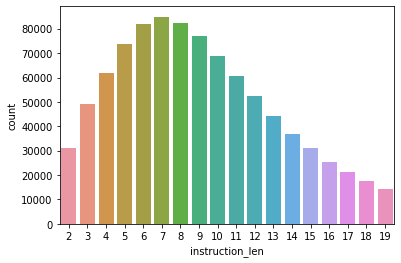

In [0]:
# Histogram of number of instruction steps per recipe
import seaborn as sns
print("Average number of instruction steps:",df['instruction_len'].mean())
sns.countplot(df['instruction_len'])

Average number of ingredients: 8.615723117715007


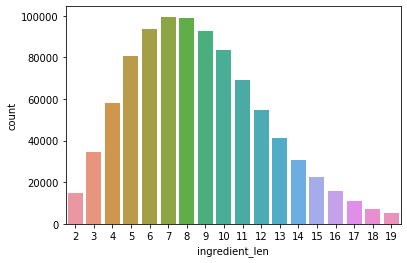

In [0]:
# Histogram of number of ingredients used per recipe
print("Average number of ingredients:",df['ingredient_len'].mean())
sns.countplot(df['ingredient_len'])

Number of unique ingredients: 16372


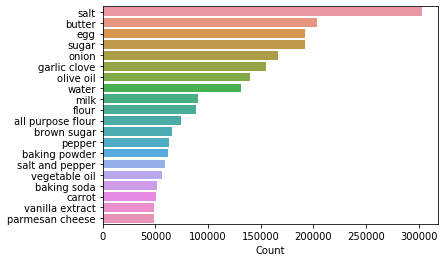

In [0]:
# Top 20 most frequently used recipes
master_ingre = [j for i in df['ingredients'].tolist() for j in i]
from collections import Counter
#Counter(master_ingre).keys() # equals to list(set(words))
#Counter(master_ingre).values() # counts the elements' frequency
ingre_df = pd.DataFrame.from_dict(Counter(master_ingre), orient='index', columns=['Count'])
print("Number of unique ingredients:",len(ingre_df))
sns.barplot(y = ingre_df.sort_values('Count', ascending=False).head(20).index, x = "Count", data = ingre_df.sort_values('Count', ascending=False).head(20))

LDA Topic Modeling

In [0]:
# Remove warning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

In [0]:
# Imports and package installation
!pip install gensim
!pip install pyLDAvis
!pip install vega
!pip install altair

     |████████████████████████████████| 1.6MB 3.4MB/s 
     |████████████████████████████████| 552kB 42.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=00b7f8186e9a76162fdc789a0e246d309110e836b6aa5f5699209ede1f40df37
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=4e610305b08c9cadd3f9575552adcdbf5574c68366b5145a63f65467fc236859
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
     |████████████████████████████████| 2.2MB 3.5MB/s 


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora
from gensim.models.ldamodel import LdaModel

import pyLDAvis.gensim

import altair as alt
alt.renderers.enable('colab')
print('Altair successfully loaded.')

In [0]:
# create corpus for ingredients and instructions
df['ingrs'] = df['ingredients1'].apply(', '.join)
df['instr'] = df['instructions'].apply('. '.join)

In [0]:
# Overview of dataframe
df.head()

,id,instructions,ingredients,title,instruction_len,ingredient_len,ingredients1,ingrs,instr
0,000033e39b,[cook macaroni according to package directions...,"[elbow macaroni, american cheese, celery, gree...",dilly macaroni salad recipe,8,9,"[elbow_macaroni, american_cheese, celery, gree...","elbow_macaroni, american_cheese, celery, green...",cook macaroni according to package directions....
1,000035f7ed,[add the tomatoes to 1 food processor with 1 p...,"[tomato, kosher salt, red onion, green bell pe...",gazpacho,4,9,"[tomato, kosher_salt, red_onion, green_bell_pe...","tomato, kosher_salt, red_onion, green_bell_pep...",add the tomatoes to 1 food processor with 1 pi...
2,00004320bb,"[dissolve jello in boiling water., allow to co...","[watermelon gelatin, boiling water, cool whip,...",cool and easy creamy watermelon pie,7,5,"[watermelon_gelatin, boiling_water, cool_whip,...","watermelon_gelatin, boiling_water, cool_whip, ...",dissolve jello in boiling water.. allow to coo...
3,0000631d90,"[in 1 large skillet, toast the coconut over me...","[shredded coconut, lean ground beef, fresh gar...",easy tropical beef skillet,6,10,"[shredded_coconut, lean_ground_beef, fresh_gar...","shredded_coconut, lean_ground_beef, fresh_garl...","in 1 large skillet, toast the coconut over med..."
4,000075604a,[pierce the skin of the chicken with 1 fork or...,"[chicken thigh, tea, white pepper]",kombu tea grilled chicken thigh,5,3,"[chicken_thigh, tea, white_pepper]","chicken_thigh, tea, white_pepper",pierce the skin of the chicken with 1 fork or ...


Topic Modeling Reference
https://colab.research.google.com/github/grantmlong/itds2018/blob/master/lecture-12/DataDive-Lecture12.ipynb#scrollTo=w_y69SB3MZTN

Let's both vectorize and tokenize our text.

Ingredients Topic Modeling:
Discovering presence of different cuisines within recipe1M dataset

In [0]:
# Vectorize and tokenize ingredient lists
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=8,
                             max_features=1000,
                             stop_words='english'
                            )

X_text = pd.DataFrame((vectorizer.fit_transform(df.ingrs)>0).toarray())
all_words = vectorizer.get_feature_names()
d = {i : all_words[i] for i in range(len(all_words))}

tokens = [[d[j] for j in X_text.columns[X_text.loc[i]].tolist()] for i in range(X_text.shape[0])]

print(np.random.choice(tokens, 2))

[list(['all_purpose_flour', 'baking_powder', 'butter', 'egg', 'honey', 'kosher_salt', 'low_fat_buttermilk', 'nonstick_cooking_spray', 'sharp_cheddar_cheese', 'yellow_cornmeal'])
 list(['carrot', 'chickpea', 'cumin_seed', 'egg', 'flat_leaf_parsley', 'fresh_lemon_juice', 'garlic_clove', 'lemon', 'lemon_wedge', 'olive_oil', 'onion', 'parsnip'])]


In [0]:
# use gensim's built in functionality to create a dictionary and bag of words
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

In [0]:
# train model and print topics
ldamodel = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=2,update_every=5, random_state=123456)
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.068*"egg" + 0.067*"butter" + 0.065*"sugar"')
(1, '0.061*"sugar" + 0.041*"water" + 0.033*"orange_juice"')
(2, '0.090*"onion" + 0.050*"salt" + 0.043*"water"')
(3, '0.086*"egg" + 0.084*"salt" + 0.060*"sugar"')
(4, '0.064*"butter" + 0.060*"egg" + 0.049*"milk"')
(5, '0.059*"olive_oil" + 0.034*"dijon_mustard" + 0.032*"garlic_clove"')
(6, '0.082*"olive_oil" + 0.070*"garlic_clove" + 0.039*"parmesan_cheese"')
(7, '0.036*"garlic_clove" + 0.034*"tomato" + 0.030*"ground_cumin"')
(8, '0.118*"salt" + 0.065*"pepper" + 0.060*"butter"')
(9, '0.068*"soy_sauce" + 0.045*"garlic_clove" + 0.030*"sugar"')


In [0]:
# save ldamodels or load pre-trained ldamodels

from gensim.test.utils import datapath
ldamodel.save(DATA_PATH+'lda.model.ingredients')

# Load a potentially pretrained model from disk.
lda_ingrs = LdaModel.load(DATA_PATH+'lda.model.ingredients')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Interactive visualization of topic model using pyLDAvis
lda_display = pyLDAvis.gensim.prepare(lda_ingrs, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Instruction Topic Modeling:
Discovering presence of various cooking methods within Recipe1M dataset

In [0]:
# Vectorize and tokenize ingredient lists
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=8,
                             max_features=1000,
                             stop_words='english'
                            )

X_text = pd.DataFrame((vectorizer.fit_transform(df.instr)>0).toarray())
all_words = vectorizer.get_feature_names()
d = {i : all_words[i] for i in range(len(all_words))}

tokens = [[d[j] for j in X_text.columns[X_text.loc[i]].tolist()] for i in range(X_text.shape[0])]

print(np.random.choice(tokens, 2))

[list(['15', '20', '375', 'addition', 'almonds', 'bake', 'baking', 'batter', 'beat', 'beating', 'bowl', 'brown', 'butter', 'buttermilk', 'consistency', 'cool', 'cooled', 'cream', 'creamy', 'cups', 'eggs', 'flour', 'frosting', 'lightly', 'mix', 'mixing', 'muffin', 'muffins', 'needed', 'powder', 'remaining', 'salt', 'sift', 'small', 'smooth', 'soda', 'spray', 'spread', 'stir', 'sugar', 'time'])
 list(['10', 'adjust', 'bowl', 'bring', 'burn', 'colander', 'cook', 'cooker', 'cooking', 'cool', 'cover', 'cut', 'depending', 'drain', 'easy', 'eat', 'ginger', 'green', 'heat', 'high', 'ingredients', 'leave', 'let', 'lid', 'liquid', 'low', 'meat', 'medium', 'mix', 'oil', 'pan', 'pieces', 'pork', 'reduced', 'remove', 'set', 'sieve', 'simmer', 'sliced', 'sure', 'time', 'water'])]


In [0]:
# use gensim's built in functionality to create a dictionary and bag of words
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

In [0]:
# train model and print topics
ldamodel = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=2,update_every=5)
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.032*"oven" + 0.027*"preheat" + 0.021*"baking"')
(1, '0.048*"bake" + 0.030*"oven" + 0.027*"mix"')
(2, '0.034*"heat" + 0.031*"boil" + 0.029*"saucepan"')
(3, '0.022*"bake" + 0.020*"flour" + 0.019*"sugar"')
(4, '0.023*"cream" + 0.019*"sugar" + 0.017*"bowl"')
(5, '0.029*"ingredients" + 0.021*"food" + 0.019*"processor"')
(6, '0.019*"roll" + 0.019*"place" + 0.017*"cut"')
(7, '0.026*"bowl" + 0.023*"pepper" + 0.022*"oil"')
(8, '0.042*"cheese" + 0.021*"cook" + 0.017*"heat"')
(9, '0.024*"heat" + 0.022*"cook" + 0.020*"oil"')


In [0]:
# save ldamodels or load pre-trained ldamodels
ldamodel.save(DATA_PATH+'lda.model.instructions')

# Load a potentially pretrained model from disk.
lda_instr = LdaModel.load(DATA_PATH+'lda.model.instructions')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Interactive visualization of topic model using pyLDAvis
lda_display = pyLDAvis.gensim.prepare(lda_instr, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)